In [1]:
import os

from libs.rlinml.agent import Agent
from utils import prepare_device, prepare_env, save_reward_change, load_reward_change, plot_reward_change

In [2]:
import numpy as np
import math
import time
from itertools import count

In [3]:
# prepare env
env = prepare_env('CartPole-v1')

# prepare device
device, device_name = prepare_device()

if device_name == "cuda":
    print("device_name:cuda")
    num_episodes = 6000
else:
    print("device_name:cpu")
    num_episodes = 2000

device_name:cpu


In [4]:
hyper_params = {'GAMMA':0.99, 'BATCH_SIZE':128, 'MEMORY_SIZE':10000, 'LR':1e-4}
model_type = "classical"

agent = Agent(env, hyper_params, model_type, device)

total_steps = 0
reward_change = [] # あるエピソードにおいて、どの程度期間カートポールを立てていられていたか

EPS_START = 0.99 
EPS_END = 0.01  # Minimum epsilon greedy parameter
EPS_DECAY = 1000 # Decay rate of epsilon greedy parameter

The initial parameters of the nets:
OrderedDict([('layer1.weight', tensor([[ 3.8866e-01,  3.7015e-01,  3.1500e-01, -4.3993e-01],
        [-1.3038e-02,  1.6678e-01, -3.1662e-01, -4.2441e-01],
        [ 4.0817e-01, -1.5508e-01,  1.5819e-01,  3.8801e-01],
        [ 4.7203e-01, -2.5962e-01, -2.6532e-01,  3.5776e-01],
        [ 8.2821e-02,  2.9440e-01,  2.0595e-01,  4.0040e-01],
        [-2.4718e-01,  4.0075e-01,  2.5526e-01,  2.2231e-01],
        [-1.4779e-01, -1.5123e-01, -1.3750e-01,  3.9473e-01],
        [-5.6602e-02,  5.1159e-02,  4.9482e-01, -1.3550e-01],
        [-4.8941e-03,  9.2048e-02,  3.0751e-01,  4.5058e-02],
        [-8.2871e-03,  2.8982e-02, -3.6821e-01,  3.1062e-01],
        [ 1.1641e-03, -1.2533e-01,  2.3526e-01,  4.6149e-01],
        [-3.4643e-01,  3.2376e-01, -3.4038e-01, -9.9203e-02],
        [ 4.1452e-01,  2.3058e-01, -2.0483e-02,  4.6453e-01],
        [-8.1999e-02, -2.1105e-01,  6.8989e-02, -3.7474e-01],
        [ 1.3477e-01, -3.4439e-01,  1.4019e-01, -3.9650e-01],
   

In [5]:
print("The epislon was initialized to " + str(EPS_START))

start = time.time()
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()

    for t in count():
        epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * total_steps / EPS_DECAY)
        action = agent.get_action(state, epsilon)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = observation

        # Store the transition in memory
        agent.store_experience(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        total_steps += 1
        # Perform one step of the optimization (on the policy network)
        agent.optimize_model()

        # Soft update of the target network's weights
        agent.softupdate_target_network(0.005)

        if done:
            reward_change.append(t+1)
            break

    if (i_episode+1)%10 == 0:
        avg_rewards = np.mean(reward_change[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(i_episode+1, num_episodes, avg_rewards))
        if avg_rewards >= 500.0:
            break

end = time.time()
print('Complete')
print("It takes {} minitues".format((end-start)/60))

print(os.getcwd())
PATH = os.getcwd()
save_reward_change(reward_change, PATH, file_name="reward_change_classical.txt")
agent.save_model(PATH)

The epislon was initialized to 0.99
Episode 10/2000, average last 10 rewards 17.7
Episode 20/2000, average last 10 rewards 18.6
Episode 30/2000, average last 10 rewards 15.9
Episode 40/2000, average last 10 rewards 13.4
Episode 50/2000, average last 10 rewards 14.0
Episode 60/2000, average last 10 rewards 11.4
Episode 70/2000, average last 10 rewards 13.2
Episode 80/2000, average last 10 rewards 15.3
Episode 90/2000, average last 10 rewards 16.3
Episode 100/2000, average last 10 rewards 19.6
Episode 110/2000, average last 10 rewards 13.7
Episode 120/2000, average last 10 rewards 9.8
Episode 130/2000, average last 10 rewards 11.1
Episode 140/2000, average last 10 rewards 10.3
Episode 150/2000, average last 10 rewards 10.5
Episode 160/2000, average last 10 rewards 9.6
Episode 170/2000, average last 10 rewards 9.6
Episode 180/2000, average last 10 rewards 9.3
Episode 190/2000, average last 10 rewards 9.7
Episode 200/2000, average last 10 rewards 9.6
Episode 210/2000, average last 10 rewar

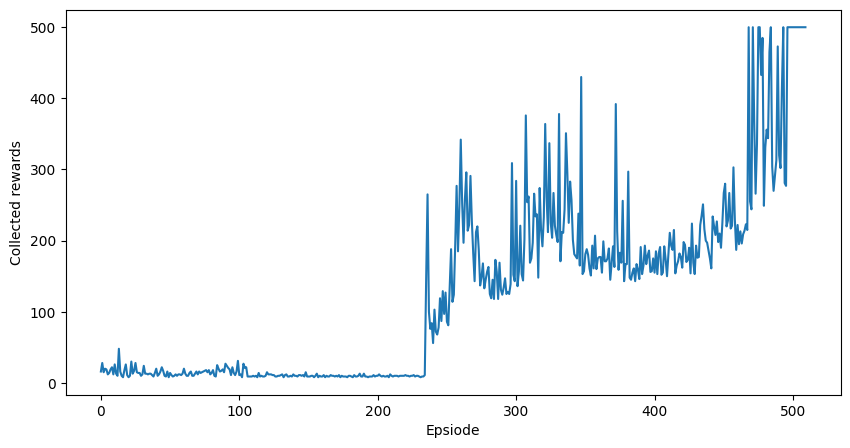

In [6]:
plot_reward_change(reward_change)

In [7]:
reward_change_loaded = load_reward_change(PATH, file_name="reward_change_classical.txt")

In [8]:
print(reward_change_loaded)

[16, 28, 15, 20, 19, 12, 14, 19, 22, 12, 26, 13, 10, 48, 16, 10, 8, 18, 26, 11, 8, 10, 30, 13, 17, 28, 15, 14, 14, 10, 12, 24, 13, 13, 12, 13, 13, 11, 9, 14, 20, 10, 12, 16, 22, 17, 10, 9, 16, 8, 14, 11, 9, 10, 12, 10, 12, 12, 11, 13, 20, 13, 10, 10, 14, 16, 10, 10, 13, 16, 12, 16, 14, 15, 16, 17, 18, 15, 18, 12, 14, 18, 10, 9, 25, 20, 16, 17, 19, 15, 27, 24, 21, 19, 11, 22, 14, 11, 16, 31, 11, 12, 8, 27, 21, 22, 9, 9, 9, 9, 10, 9, 10, 8, 14, 9, 10, 9, 9, 10, 15, 12, 12, 12, 11, 11, 9, 9, 10, 10, 11, 12, 8, 11, 12, 9, 9, 10, 9, 12, 10, 10, 9, 11, 11, 10, 11, 9, 15, 9, 9, 9, 10, 10, 8, 10, 13, 8, 10, 9, 9, 11, 8, 10, 9, 9, 11, 10, 10, 9, 10, 9, 11, 8, 10, 9, 9, 9, 8, 10, 10, 9, 8, 11, 9, 9, 10, 13, 9, 9, 13, 9, 9, 8, 9, 9, 9, 11, 9, 10, 10, 12, 10, 9, 10, 9, 9, 10, 8, 12, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 11, 10, 10, 9, 10, 10, 11, 9, 10, 10, 9, 8, 9, 9, 11, 147, 265, 100, 76, 84, 56, 103, 72, 68, 78, 119, 87, 129, 97, 127, 86, 81, 135, 188, 114, 124, 195, 277, 185, 248, 342, 253, 1